# Counterfactual Transportability - Advanced Features

This notebook is a demonstration of some of the debugging features in the $Y_0$ implementation of algorithms from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf).

In [1]:
import logging

from y0.algorithm.counterfactual_transport.api import (
    CFTDomain,
    conditional_cft,
    unconditional_cft,
)
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    TARGET_DOMAIN,
    X1,
    Pi1,
    R,
    Variable,
    W,
    X,
    Y,
    Z,
)
from y0.graph import NxMixedGraph

## Insight into how the algorithms work

We can run the previous two models with the debugger enabled for more insight into what's going on under the hood. Let's load up our example from the basic Counterfactual Transportability notebook:

In [2]:
Vaccinated = Variable("V")
Antibody = Variable("A")
Infected = Variable("I")

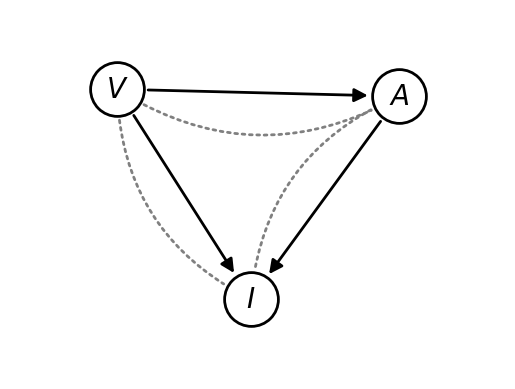

In [3]:
# This graph represents the target domain, the United States.
USA = Variable("USA")

observational_study_in_usa_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Vaccinated, Antibody), (Vaccinated, Infected), (Antibody, Infected)],
)
observational_study_in_usa_graph.draw()

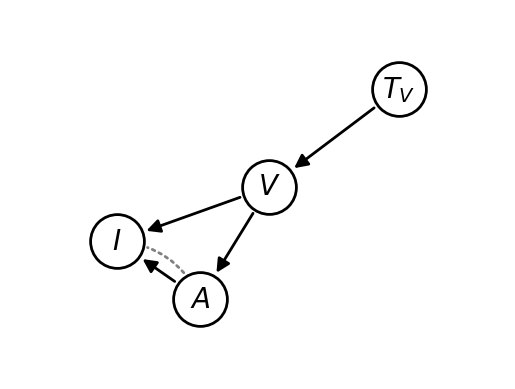

In [4]:
Australia = Variable("AUS")

vaccine_efficacy_in_australia_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (transport_variable(Vaccinated), Vaccinated),
    ],
    undirected=[(Antibody, Infected)],
)
vaccine_efficacy_in_australia_graph.draw()

In [5]:
domains = [
    CFTDomain(
        population=Australia,
        graph=vaccine_efficacy_in_australia_graph,
        policy_variables={Vaccinated},
    ),
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph,
    ),
]

# Unconditional model

In [6]:
event = [(+Infected @ -Vaccinated)]
unconditional_cft_result = unconditional_cft(
    event=event, target_domain_graph=observational_study_in_usa_graph, domains=domains
)
unconditional_cft_result.expression

Sum[A](PP[AUS](A | V) * PP[AUS](I | A, V))

We'd like to take a look at why, for our unconditional counterfactual transportability example, we transport information from Australia. Let's enable debugging, and fit the unconditional model. 

In [7]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)

By displaying the domains, we remind ourselves that it's an array with the first element representing Australia and the second, the United States.

In [8]:
domains

[CFTDomain(graph=NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x71a2bf8b7d90>, undirected=<networkx.classes.graph.Graph object at 0x71a2c1c21dd0>), population=PP[AUS](A, I, V), policy_variables={V}, ordering=None),
 CFTDomain(graph=NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x71a2c31b4110>, undirected=<networkx.classes.graph.Graph object at 0x71a2c31b4b50>), population=PP[USA](A, I, V), policy_variables=set(), ordering=None)]

Let's fit the model.

In [9]:
event = [(+Infected @ -Vaccinated)]
unconditional_cft_result = unconditional_cft(
    event=event, target_domain_graph=observational_study_in_usa_graph, domains=domains
)
unconditional_cft_result.expression

DEBUG:y0.algorithm.counterfactual_transport.api:In unconditional_cft: domain_data = [({V}, PP[AUS](A, I, V)), (set(), PP[USA](A, I, V))]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: minimized_event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 1 of line 3: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after line 2: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 2 of line 3: minimized_reflexive_variable_to_value

Sum[A](PP[AUS](A | V) * PP[AUS](I | A, V))

For the unconditional model (which maps to Algorithm 2 of [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf)), we look at Australia first. 

1. The unconditional counterfactual transportability algorithm first _simplifies_ the query as per Algorithm 1 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf). The simplification checks for inconsistencies in the counterfactual question, such as cases where the same counterfactual variable is passed in twice and has two different values for that variable. It also gets rid of duplicate variables in the query. See Algorithm 1 for more specifics. The debugging output that mentions the `simplify` algorithm all has to do with Algorithm 1, which is called as a preprocessing step for Algorithm 2.
    
2. The unconditional counterfactual transportability algorithm computes an _ancestral set_: the counterfactual ancestors of the outcome variables in the target domain graph. (Ancestors of a counterfactual variable as defined in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf) are different than mere ancestors of a variable in a graph, and are not immediately obvious from looking at the graph.)

3. Next the algorithm groups the variables in this set into _counterfactual factors_, that is, groups of variables connected by bi-directed edges in the target domain graph. In this example there is only one counterfactual factor, as indicated by the debugging output, `factorized_ancestral_set_with_values = [{(I @ (-A, -V), +I), (A @ -V, None)}]` (the list contains one element). 

4. The algorithm checks to see if any of these counterfactual factors are _inconsistent_ (see Line 3 of Algorithm 2, as well as Definition 4.1, in the paper). One way counterfactual factors can be inconsistent is if for some variable _W_ in the counterfactual factor, _W_ is intervened on with value _t_ of variable _T_, yet variable _T_ is also in the counterfactual factor and has value _t'_. That is, we are considering _W_ in a world in which _T_ is set to _t_, but actually we observe that _T_ is set to _t'_. In the debugging output, we can see that inconsistency show up if the dictionary returned by `_any_variable_values_inconsistent_with_interventions` contains any entry that has more than two values. The second way counterfactuals can be inconsistent is if two different counterfactual variables in the counterfactual factor (say _W1_ and _W2_) both are intervened on for some variable _T_, but for _W1_ _T_ is set to _t_ and for _W2_, _T_ is set to _t'_. In such a case, the dictionary returned by `_any_inconsistent_intervention_values` will have a dictionary key that has more than one value associated with it.

5. For each (source) domain and for each counterfactual factor, the algorithm conducts a check to see whether any vertex in the factor for the domain is in the set of policy variables for that domain, or is a transportability node. If there exists such a vertex (i.e., the check fails), we cannot transport that counterfactual factor from that domain, and move on to the next available domain. We start with the first domain in the `domains` array (Australia), and this check passes for Australia. (In [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf), this step takes place in Algorithm 4, which is called from Algorithm 2.)

6. For each source domain / counterfactual factor combination that passes the check in Step 5, the unconditional counterfactual transportability algorithm then runs the Tian-Pearl Identification algorithm on each counterfactual factor from Step 5. If the counterfactual factor is identified, then that counterfactual factor is transportable from the associated source domain to the target domain. (This call is Algorithm 5 of [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf), which is called from Algorithm 4.) Were the check in Step 5 to fail or the Tian-Pearl Identification algorithm to show that the counterfactual factor is not identified for that domain, then (per Algorithm 4 of the paper) the unconditional counterfactual transportability algorithm keeps trying additional domains for that counterfactual factor until all domains have been tried or the algorithm finds a domain for which the factor is transportable.

   To understand the debugging output for Step 6, look at the two sets of outputs from `y0.algorithm.tian_id` that are separated by one line of output from `y0.algorithm.counterfactual_transport.api`. The first set of outputs corresponds to Line 3 of Algorithm 4 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf), and is a preprocessing step for the actual Tian-Pearl Identify algorithm. For the domain graph in question, this preprocessing step computes the probability of the set of vertices connected by bidirected edges that contain the counterfactual factor passed in to this part of the algorithm. The line of debugging output from `y0.algorithm.counterfactual_transport.api` separating the two sets of outputs from `y0.algorithm.tian_id` displays the result of this preprocessing step. That probability is then passed in to the actual Tian-Pearl identify algorithm (`identify_district_variables`), which reports a few intermediate steps and data structures in Algorithm 5 of [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf) and the value it returns.

In this manner the unconditional counterfactual transportability algorithm loops through all the counterfactual factors and either returns `None` if any counterfactual factor cannot be transported for all source domains, or else (as in the present case) combines the probabilities associated with each transported counterfactual factor as specified by the algorithm and returns the result as per the next step.

7. Step 7 is the last line of Algorithm 2 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf). The step multiplies together the results from Steps 5 and 6 for each counterfactual factor (only one in the present case, because there was only one counterfactual factor coming out of Step 3). Next, the step sums that product over all the variables in the ancestral set from Step 2 above that are not outcome variables in the original counterfactual question. In the present case the original counterfactual question, `[(+Infected @ -Vaccinated)]`, contains one outcome variable (`Infected`), and the ancestral set in Line 2 contains two variables (`Infected` and `Antibody`). So, Step 7 sums over `Antibody` to return `Sum[A](PP[AUS](A | V) * PP[AUS](I | V, A))` as displayed above. (Note that this probabilistic expression is equivalent to `PP[AUS](I | V)`, and implementation of a $Y_0$ subroutine to simplify probabilistic expressions is currently future work.)

# Conditional model

We saw in the "Counterfactual Transportability" notebook a simple conditional counterfactual transportability question that is identified for Australia and not for the United States. Let's run the model with the debugger and see why that was so. First, we set up the model as before:

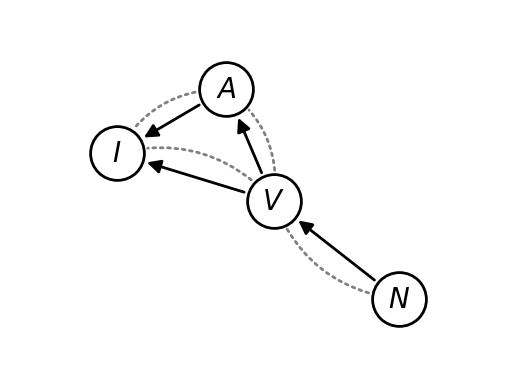

In [10]:
Neighborhood = Variable("N")

# This graph represents the target domain, the United States.
observational_study_in_usa_graph_2 = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
        (Neighborhood, Vaccinated),
    ],
    undirected=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (Neighborhood, Vaccinated),
    ],
)
observational_study_in_usa_graph_2.draw()

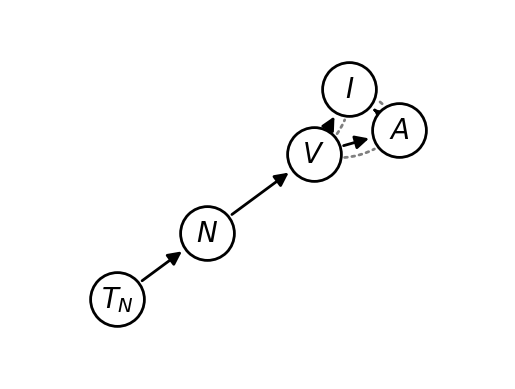

In [11]:
vaccine_efficacy_in_australia_graph_2 = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (transport_variable(Neighborhood), Neighborhood),
        (Neighborhood, Vaccinated),
    ],
    undirected=[(Antibody, Infected), (Antibody, Vaccinated), (Infected, Vaccinated)],
)
vaccine_efficacy_in_australia_graph_2.draw()

In [12]:
domains2 = [
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph_2,
    ),
    CFTDomain(
        population=Australia,
        graph=vaccine_efficacy_in_australia_graph_2,
        policy_variables={Neighborhood},
    ),
]

In [13]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ +Vaccinated],
    conditions=[+Vaccinated @ -Neighborhood],
    target_domain_graph=observational_study_in_usa_graph_2,
    domains=domains2,
)

conditional_cft_result.expression

DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: ancestral_sets = {frozenset({V @ -N}), frozenset({A @ +V, I @ +V})}
DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: computed these ancestral components: frozenset({frozenset({A @ +V, V @ -N, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: ancestral_components = frozenset({frozenset({A @ +V, V @ -N, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variables = {I @ +V}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variable_to_value_mappings = {I @ +V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: condition

((Sum[A](PP[AUS](A | V, N) * PP[AUS](I | A, V, N) * PP[AUS](V | N)) / Sum[A, I](PP[AUS](A | V, N) * PP[AUS](I | A, V, N) * PP[AUS](V | N))))

The following steps take place:

1. The conditional algorithm starts by computing _ancestral components_, that is, groups of ancestral sets that are unioned together in cases where two sets are not disjoint or members of the sets are connected by bidirected edges (see section 4.1 of [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf)). In this case we have one ancestral component comprised of the variables $I_{do(V = +v)}, A_{do(V=+v)}, V_{do(N=-n)}$, represented in Y0 as `{I @ +V, A @ +V, V @ -N})}`. 

2. The conditional algorithm then finds all the ancestral components containing outcome variables and generates the set of counterfactual variables in those components with their corresponding values, if they are known. Those variables and values get passed through to a call to the unconditional algorithm, treating them as outcome variables and values for an unconditional counterfactual question. Since $I_{do(V=+v)}$ is an outcome variable, that means we pass all three variables in our single ancestral component to the unconditional algorithm. 

The unconditional algorithm runs as previously. Without going into quite as much detail about the debugging output as in the previous example, here are the essential points:

3. The unconditional counterfactual transportability algorithm computes an _ancestral set_: `{(A @ +V, None), (I @ (-A, +V), +I), (V @ -N, +V)}`. 

4. Next the unconditional algorithm groups the variables in this set into _counterfactual factors_. Here that result is a single counterfactual factor: `[{(A @ +V, None), (I @ (-A, +V), +I), (V @ -N, +V)}]`

5. For each (source) domain and for each counterfactual factor, the unconditional algorithm conducts a check to see whether any vertex in the factor for the domain is in the set of policy variables for that domain, or is a transportability node. If there exists such a vertex (i.e., the check fails), we cannot transport that counterfactual factor from that domain, and move on to the next available domain. The unconditional algorithm starts with the first domain in the `domains` array (the United States), and this check passes for the United States. Therefore:

6. For the United States, the unconditional algorithm runs the Tian-Pearl Identification algorithm to see if the counterfactual factor in question is identified as a prerequisite for transporting the counterfactual factor from the associated source domain to the target domain. In this case, the counterfactual factor is not identified for the United States as represented by the debugging output `In identify_district_variables: A = T. Returning None (i.e., FAIL).`. In technical terms, the reason is that the graph for the United States contains a bidirected edge between $N$ and $V$. The Tian-Pearl identification algorithm tries to identify a "C-component" containing $A$, $I$, and $V$ (the vertices in the set **$C$** in the Tian-Pearl ID algorithm), but in the domain graph for the United States those vertices are part of a larger "C-Component" containing vertex $N$ (so $A$, $I$, and $V$ are part of the set **$T$** in the Tian-Pearl ID algorithm). Since the ancestors of **$C$** in the subgraph of the United States graph containing vertices in **$T$** are equivalent to the set **$T$** (see Lines 1 and 3 of the Tian-Pearl ID algorithm as reproduced in Algorithm 5 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf)), the Tian-Pearl ID algorithm therefore returns FAIL. 

7. The unconditional algorithm therefore moves on to the next available domain for the single counterfactual factor in question, Australia.

8. The unconditional algorithm repeats the check in Step 5 and passes it.

9. The Tian-Pearl Identification algorithm then runs again -- for Australia -- and this time the counterfactual factor is identified. That is because the set $\mathbf{T}$ in that graph does not include vertex $N$ and therefore we get a different result when computing the ancestors of $\mathbf{C}$ in the subgraph of the Australia graph containing vertices in $\mathbf{T}$. Those ancestors of $\mathbf{C}$ are just $\mathbf{C}$ again, and so the Tian-Pearl Identification algorithm returns `P^{AUS}(A | V, N) P^{AUS}(I | A, V, N) P^{AUS}(V | N)` (see Line 2 of Algorithm 5 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf)). 

10. The unconditional counterfactual transportability algorithm sums the result from Step 9 over all the variables in the ancestral set from Step 3 that are not variables in the outcome variable set for the unconditional algorithm as computed in Step 2. But since every variable in the Step 3 ancestral set is also in the query to the unconditional algorithm from Step 2, no summation takes place and the unconditional algorithm just passes the result from Step 9 back to the conditional algorithm with no modifications. That result is saved as $Q$ on Line 3 of Algorithm 3 in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf). 

Now, back in the conditional algorithm, the algorithm takes $Q$ from Step 10 and returns a quotient:

11. To get the numerator the algorithm checks to see what variables are in the ancestral components passed to the unconditional algorithm that are neither outcome variables nor conditioned variables in the original query. Those are just a set containing one variable ${A}$ (Antibody), and the conditional algorithm takes the result $Q$ and sums it over that variable $A$ to compute the numerator. 

12. To get the denominator the algorithm checks to see what variables are in the ancestral components passed to the unconditional algorithm that are not conditioned variables in the original query, and those are the set $A, I$. The denominator therefore sums $Q$ over $A$ and $I$. 

Thus, the conditional algorithm returns the expression $\frac{\sum\limits_{A} P^{AUS}(A | V, N) P^{AUS}(I | A, V, N) P^{AUS}(V | N)}{\sum\limits_{A, I} P^{AUS}(A | V, N) P^{AUS}(I | A, V, N) P^{AUS}(V | N)}$. (That expression could be further simplified to `PP[AUS](I | V, N)`, and implementation of a $Y_0$ subroutine to simplify probabilistic expressions is currently future work.)

# A conditional model is sometimes identified where its unconditional equivalent is not

In the basic example we saw that an unconditional counterfactual transportability model is not identified for the United States, despite that being an observational graph with many confounding variables present. It turns out that we can specify a similar conditional query and it is identified for the United States. Let's run both the conditional model and the unconditional equivalent with the debugger enabled and explore why that is so.

In [14]:
US_only_domain = [
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph,
    ),
]

In [15]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ +Vaccinated],
    conditions=[+Vaccinated],
    target_domain_graph=observational_study_in_usa_graph,
    domains=US_only_domain,
)

conditional_cft_result.expression

DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: ancestral_sets = {frozenset({V}), frozenset({A @ +V, I @ +V})}
DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: computed these ancestral components: frozenset({frozenset({A @ +V, V, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: ancestral_components = frozenset({frozenset({A @ +V, V, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variables = {I @ +V}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variable_to_value_mappings = {I @ +V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: conditioned_variable_to_

((Sum[A](PP[USA](A | V) * PP[USA](I | A, V) * PP[USA](V)) / Sum[A, I](PP[USA](A | V) * PP[USA](I | A, V) * PP[USA](V))))

In [16]:
unconditional_cft_result = unconditional_cft(
    event=[+Infected @ +Vaccinated],
    target_domain_graph=observational_study_in_usa_graph,
    domains=US_only_domain,
)

unconditional_cft_result is None

DEBUG:y0.algorithm.counterfactual_transport.api:In unconditional_cft: domain_data = [(set(), PP[USA](A, I, V))]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: event = [(I @ +V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: minimized_event = [(I @ +V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 1 of line 3: minimized_nonreflexive_variable_to_value_mappings = {I @ +V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after line 2: minimized_nonreflexive_variable_to_value_mappings = {I @ +V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 2 of line 3: minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.a

True

The two algorithms return different results because the first step of the conditional counterfactual transportability algorithm (computing _ancestral components_) ends up expanding the query passed to the unconditional transportability algorithm to include more counterfactual variables in the unconditional query than existed in the conditional query. For this example, having more variables in the ancestral component caused the conditional query to be identified where the unconditional query is not. In the present case, the previous unconditional query boiled down to running the Tian-Pearl identification algorithm on a counterfactual factor containing the vertices Antibody and Infected; for the conditional query, that counterfactual factor expands to include Vaccinated, and for the same reason that the Tian-Pearl identification algorithm returned a result in Step 10 of the previous example, the Tian-Pearl identification algorithm returns a result here.

# Detecting Inconsistent Counterfactual Factors

In some cases, a query may fail because counterfactual factors are _inconsistent_ -- that is, if the query results in a variable in a counterfactual factor being simultaneously set to more than one value, or if one of the parents of a variable in a counterfactual factor is simultaneously set to more than one value. In such cases, the algorithm returns `None`, and running the query in debug mode yields insight into which counterfactual factor (or factors) are inconsistent and why.  

In [17]:
# Revised version of conditional_cft(), after we include conditioned variable values that are part of
# outcome ancestral components in the call to transport_unconditional_counterfactual_query()
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ -Vaccinated],
    conditions=[+Vaccinated],
    target_domain_graph=observational_study_in_usa_graph,
    domains=domains,
)

conditional_cft_result is None

DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: ancestral_sets = {frozenset({V}), frozenset({I @ -V, A @ -V})}
DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: computed these ancestral components: frozenset({frozenset({I @ -V, A @ -V, V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: ancestral_components = frozenset({frozenset({I @ -V, A @ -V, V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variables = {I @ -V}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: conditioned_variable_to_

True

In the above case, we ask for the probability that an individual is infected given they are vaccinated, in a world in which we make them not be vaccinated. The query is inconsistent, and it returns FAIL. We see that the consistency check finds two values for the _vaccinated_ vertex _V_.

# Debugging Misconfigured Queries

$Y_0$ has a robust interface for detecting misconfigured queries. Here is an example where the conditional algorithm is run when there are no conditioned variables, and the user is prompted to run the unconditional algorithm instead:

In [18]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ -Vaccinated],
    conditions=[],
    target_domain_graph=observational_study_in_usa_graph,
    domains=domains,
)

conditional_cft_result.expression

ValueError: In _validate_transport_conditional_counterfactual_query_input: empty list for the conditions. Check your inputs or consider directly calling transport_unconditional_counterfactual_query().

## User interface demonstration

The following exercise is from a tutorial at Pacific Northwest National Laboratory that demonstrates that detailed validation of user inputs makes using the software easy. We've deliberately included some typos in the problem solution and show the software catching them. Feel free to experiment with the input parameters and generate other errors!

1. Construct a graph with the following edges:
   ```
   X1 -> Z,
   R -> Z,
   Z -> W,
   W -> Y,
   W <-> Z	
   ```
2. Consider you have available observational data from the target domain, and an experiment from Domain 1 in which $W$ is fixed to be only a function of $Z$ (breaking the bidirected edge between $W$ and $Z$), and $R$ is drawn from a different population than in the target domain.
3. Estimate $P(Y_{X1},W_{R}|X1)$ with the values ${-Y,-W,-X}$ respectively.

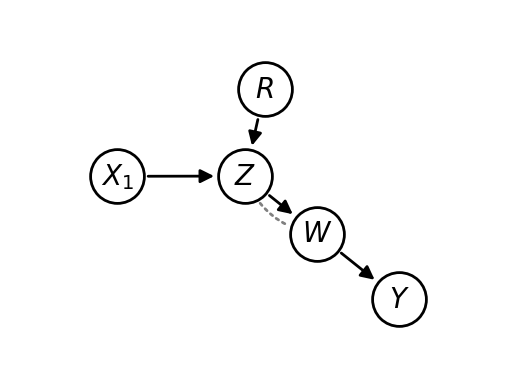

In [19]:
target_domain_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
    ],
    undirected=[(Z, W)],
)
target_domain_graph.draw()

In [20]:
break_w_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
        (transport_variable(R), R),
    ],
)
# break_w_graph.draw()

In [21]:
outcomes = [-Y @ -X1, -W @ -R]
conditions = [-X]  ## NOTE: Should be X1

target_domain_graph_topo = list(target_domain_graph.topological_sort())
break_w_graph_topo = list(break_w_graph.topological_sort())
domains = [
    CFTDomain(
        population=Pi1,
        graph=break_w_graph,
        ordering=break_w_graph_topo,
        policy_variables={W},
    ),
    CFTDomain(
        population=TARGET_DOMAIN,
        graph=target_domain_graph,
        # This is an intentionally incorrect topological ordering. To fix, do so manually or comment out the line entirely.
        ordering=[W, X1, R, Z, Y],
    ),
]
try:
    result = conditional_cft(
        outcomes=outcomes,
        conditions=conditions,
        target_domain_graph=target_domain_graph,
        domains=domains,
    )
    result.display()
except ValueError as e:
    print("error", e)

error In _validate_transport_conditional_counterfactual_query_input: one of the input conditioned variables is not in the target domain graph. Check your inputs. 
